# Kaggle challenge: Give Me Some Credit

https://www.kaggle.com/c/GiveMeSomeCredit
### 1) Objective: 
Improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years.
### 2) Please submit your code (Python + a github repo)
### 3) Answer the following questions:
- Tell us how you validate your model, which, and why you chose such evaluation technique(s).
- What is AUC? Why do you think AUC was used as the evaluation metric for such a problem? What are other metrics that you think would also be suitable for this competition?
- What insight(s) do you have from your model? What is your preliminary analysis of the given dataset?
- Can you get into the top 100 of the private leaderboard, or even higher?

In [8]:
from platform import python_version
print(python_version())

3.8.5


In [9]:
#import libraries
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost
import lightgbm

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [10]:
notebook_path = os.path.abspath("machinelearning_foodpanda.ipynb")
train_csv = os.path.join(os.path.dirname(notebook_path), 'data/cs-training.csv')
test_csv = os.path.join(os.path.dirname(notebook_path), 'data/cs-test.csv')
sample_test = os.path.join(os.path.dirname(notebook_path), 'data/sampleEntry.csv')

In [11]:
cols = ['SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

In [12]:
# read data
data = pd.read_csv(train_csv, usecols=cols)
test = pd.read_csv(test_csv, usecols=[c for c in cols if c != 'SeriousDlqin2yrs'])
sampleEntry = pd.read_csv(sample_test, index_col=False)

### 1) EDA

In [13]:
data.head(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


In [14]:
data.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

In [15]:
data.shape

(150000, 11)

In [16]:
data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

#### a) Missing values

In [17]:
data.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [18]:
#percentage of missing values by column
round(data.isnull().sum()/len(data)*100,1)

SeriousDlqin2yrs                         0.0
RevolvingUtilizationOfUnsecuredLines     0.0
age                                      0.0
NumberOfTime30-59DaysPastDueNotWorse     0.0
DebtRatio                                0.0
MonthlyIncome                           19.8
NumberOfOpenCreditLinesAndLoans          0.0
NumberOfTimes90DaysLate                  0.0
NumberRealEstateLoansOrLines             0.0
NumberOfTime60-89DaysPastDueNotWorse     0.0
NumberOfDependents                       2.6
dtype: float64

MonthlyIncome and NumberOfDependents have 29731 (19.82%) and 3924 (2.61%) null values respectively

In [19]:
# records that have ore than 1 missing values
len(data.loc[data.isnull().sum(axis=1)>1])

3924

In [20]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


We notice the same maximum value 98 for NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate and NumberOfTime60-89DaysPastDueNotWorse

In [21]:
data.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

This is a binary classification - The data is unbalanced

#### b) Visualisation

age

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age'>

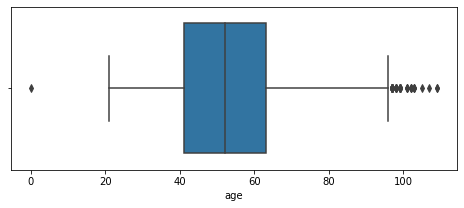

In [22]:
plt.figure(figsize=(8,3))
sns.boxplot(data['age'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DebtRatio'>

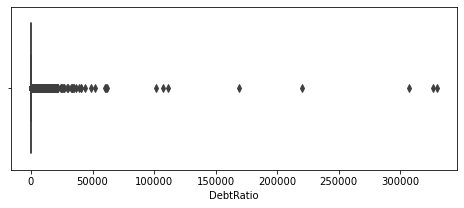

In [23]:
plt.figure(figsize=(8,3))
sns.boxplot(data['DebtRatio'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NumberOfTime30-59DaysPastDueNotWorse'>

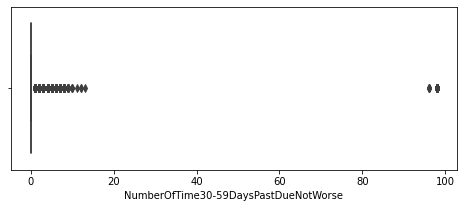

In [24]:
plt.figure(figsize=(8,3))
sns.boxplot(data['NumberOfTime30-59DaysPastDueNotWorse'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NumberOfTime60-89DaysPastDueNotWorse'>

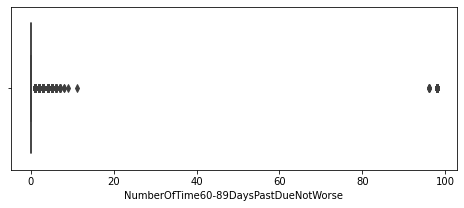

In [25]:
plt.figure(figsize=(8,3))
sns.boxplot(data['NumberOfTime60-89DaysPastDueNotWorse'])

In [26]:
len(data.loc[(data['NumberOfTime60-89DaysPastDueNotWorse']>20) & (data['SeriousDlqin2yrs']==0)])

122

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NumberOfTimes90DaysLate'>

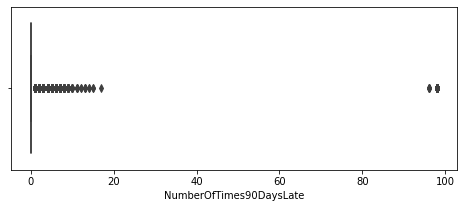

In [27]:
plt.figure(figsize=(8,3))
sns.boxplot(data['NumberOfTimes90DaysLate'])

In [28]:
len(data.loc[(data['NumberOfTimes90DaysLate']>20) & (data['SeriousDlqin2yrs']==0)])

122

In [29]:
len(data.loc[(data['NumberOfTimes90DaysLate']>20) & (data['SeriousDlqin2yrs']==1)])

147

Text(0.5, 1.0, 'SeriousDlqin2yrs = 1')

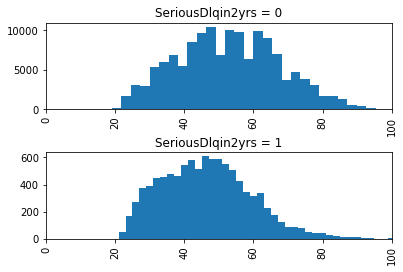

In [30]:
age_hist = data['age'].hist(by=data['SeriousDlqin2yrs'], bins=40, layout=(2,1))
age_hist[0].set_xlim((0,100))
age_hist[0].set_title('SeriousDlqin2yrs = 0')
age_hist[1].set_xlim((0,100))
age_hist[1].set_title('SeriousDlqin2yrs = 1')

Features correlation

<AxesSubplot:>

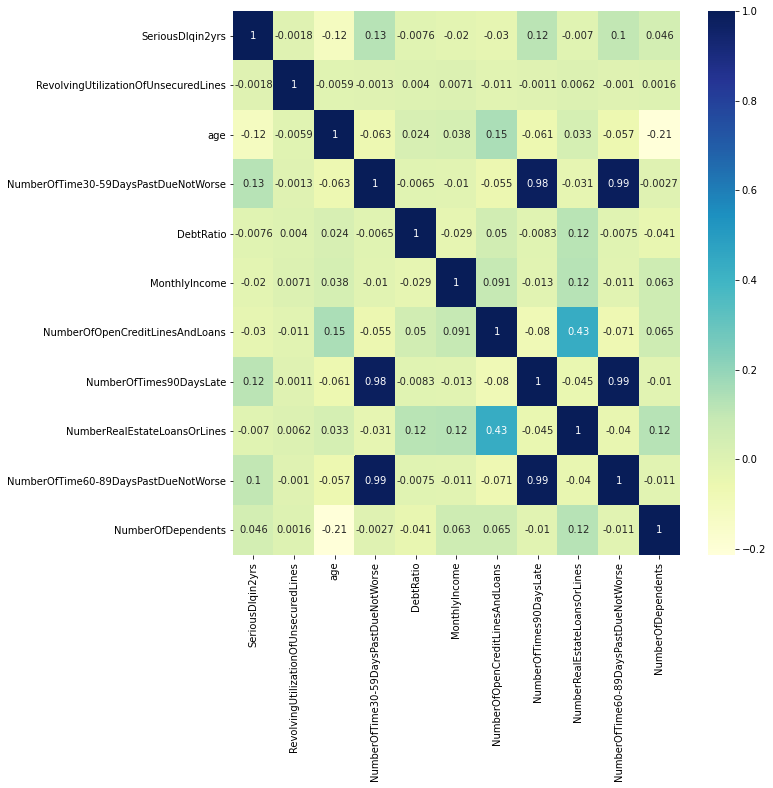

In [31]:
corr = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap="YlGnBu", annot=True)

We notice a high correlation between the features 'NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse'

### 2) Preprocessing - Feature engineering

remove outliers?
It seems this dataset contains a lot of outliers which are big enemies of linear models.
It migh also be smart to avoid using correlated features but we will certainly move to algorithms that use boostrap aggregating or boosting methods

In [32]:
age_idx = data.loc[data['age']>100].index
numberofTime_idx = data.loc[data['NumberOfTime60-89DaysPastDueNotWorse']>50].index
print(len(data))
data = data.drop(numberofTime_idx)
data = data.drop(age_idx)
print(len(data))

150000
149718


### 3) Modelling

functions

In [33]:
def create_roc_plot(y_true, probs, model):
    fpr, tpr, thr = roc_curve(y_true, probs)
    # plot the roc curve for the model
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= model)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [34]:
data.fillna(-1,inplace = True)

In [35]:
train = data.drop(["SeriousDlqin2yrs"], axis=1)
label = data["SeriousDlqin2yrs"].astype('uint8')
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=.2, stratify = label, random_state=123)

a) Baseline

In [36]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
probs_lr = lr.predict_proba(X_test)
roc_lr = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('roc_lr',roc_lr)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
probs_rf = rf.predict_proba(X_test)
roc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print('roc_rf',roc_rf)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


roc_lr 0.7874058116013443
roc_rf 0.8392843158230574


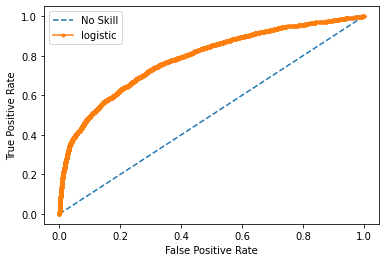

In [37]:
create_roc_plot(y_test, probs_lr[:,1], 'logistic')

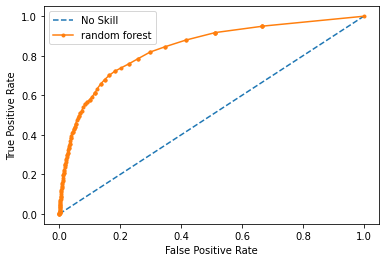

In [38]:
create_roc_plot(y_test, probs_rf[:,1], 'random forest')

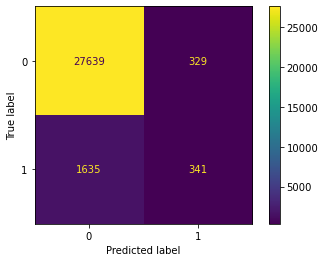

In [39]:
plot_confusion_matrix(rf, X_test, y_test)

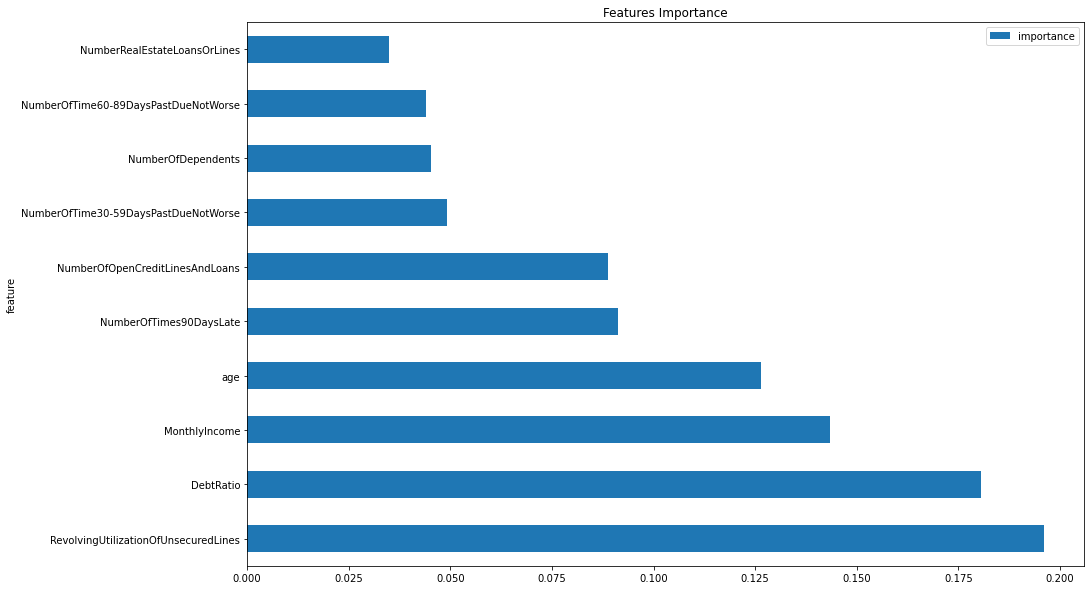

In [40]:
# feature importance
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = rf.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(15, 10))
plt.title('Features Importance')
plt.show()

b) test several models

In [41]:
tps0=time.process_time()

# Classifiers
nb = GaussianNB()
svm_ = SVC()
rf = RandomForestClassifier()
gbm = GradientBoostingClassifier()
nnet= MLPClassifier()
xgb = xgboost.XGBClassifier(n_jobs = -1)

# Number of iterations
B=3 # to test the loop : use B=3 instead

# Parameters grids
listMethGrid=[nb, svm_, rf, gbm, xgb, nnet]
arrayErreur=np.empty((B,6))

In [42]:
for i in range(B):
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(train, label, stratify=label, test_size=0.33)
    
    # Computation of test error
    for j,method in enumerate(listMethGrid):
        methFit=method.fit(X_train, y_train)
        predictions = methFit.predict(X_test)
        arrayErreur[i,j]=accuracy_score(y_test, predictions)
        
tps1=time.process_time()
print("Execution time in mn :",(tps1 - tps0)/60)

dataframeErreur=pd.DataFrame(arrayErreur,columns=["NB", "SVM", "RF", "GBM", "XGB", "NNET"])  

0
1
2
Execution time in mn : 6.7675753


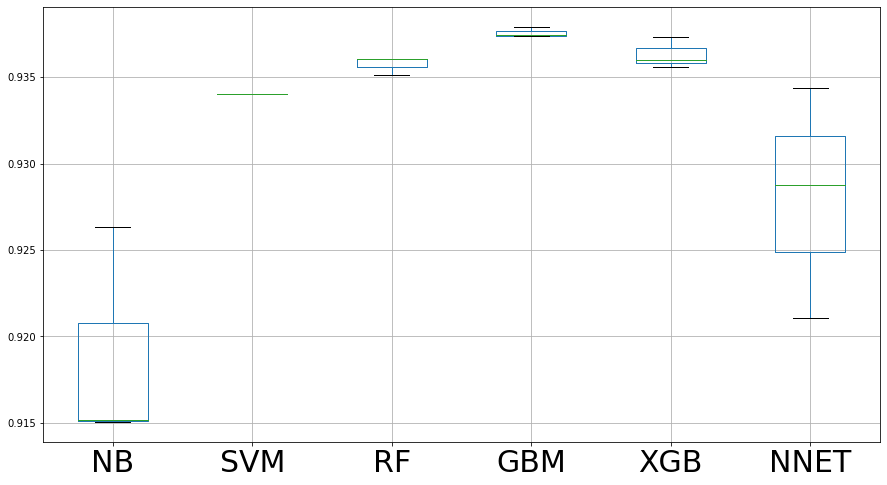

In [43]:
fig, ax = plt.subplots(figsize=(15,8))
dataframeErreur[["NB", "SVM", "RF", "GBM", "XGB", "NNET"]].boxplot(return_type='dict')
dataframeErreur.to_csv('dataframeErreur_B10.csv',index=None)
ax.set_xticklabels(["NB", "SVM", "RF", "GBM", "XGB", "NNET"],fontsize=30)
plt.show()

Best score with xgboost and gradient boosting. 
Let's try lightgbm. I like this algorithm because it's fast and efficient. It can be less sensitive to outliers and works well on large datasets. we also have interesting options for hyperparameters tuning.

### 4) Optimization

In [44]:
def stratify_kfold_evaluate(X, y, model, n_splits=3):
    lst_accu_stratified = []
    lst_prec_stratified = []
    lst_rec_stratified = []
    skf = StratifiedKFold(n_splits=n_splits)
    for train_index, test_index in skf.split(X, y):
        clone_clf = clone(model)
        X_train_folds, X_test_folds = X.iloc[train_index], X.iloc[test_index]
        y_train_folds, y_test_folds = y.iloc[train_index], y.iloc[test_index]
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_folds)
        n_correct = sum(y_pred == y_test_folds)
        lst_accu_stratified.append(n_correct/len(y_pred))
        lst_prec_stratified.append(precision_score(y_test_folds, y_pred))
        lst_rec_stratified.append(recall_score(y_test_folds, y_pred))
    return {"accuracy":lst_accu_stratified,
            "precision":lst_prec_stratified,
            "recall": lst_rec_stratified}

In [45]:
xgb = xgboost.XGBClassifier()
print(stratify_kfold_evaluate(train, label, xgb))

{'accuracy': [0.9349977958562097, 0.9357792650182343, 0.9366008095219012], 'precision': [0.5211024978466839, 0.5394973070017953, 0.5565371024734982], 'recall': [0.18372304889158822, 0.1825083510476769, 0.1913730255164034]}


In [46]:
gbm = GradientBoostingClassifier()
print(stratify_kfold_evaluate(train, label, gbm))

{'accuracy': [0.9372620526589989, 0.9380234841502024, 0.9378832204544544], 'precision': [0.575139146567718, 0.5982318271119843, 0.5935672514619883], 'recall': [0.1882781658062557, 0.18493774673549954, 0.18499392466585662]}


In [47]:
lgb = lightgbm.LGBMClassifier()
print(stratify_kfold_evaluate(train, label, lgb))

{'accuracy': [0.937001562938324, 0.9376427684046007, 0.9381036348334869], 'precision': [0.5682859761686526, 0.5920651068158698, 0.6056191467221644], 'recall': [0.1882781658062557, 0.17673853628909808, 0.1767922235722965]}


lightgbm

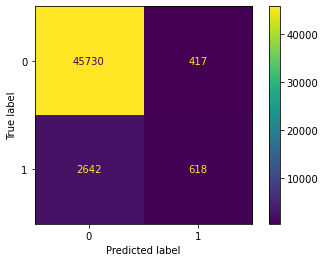

In [48]:
from sklearn.metrics import plot_confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(train, label, stratify=label, test_size=0.33)
clf = lightgbm.LGBMClassifier()
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

Optimisation lightgbm

In [49]:
def print_status(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # model cross validation results
    all_models = pd.DataFrame(SEARCH.cv_results_)  
    # Best score and best parameters    
    best_params = pd.Series(SEARCH.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(SEARCH.best_score_, 4),
        SEARCH.best_params_
    ))

In [52]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real

_ITERATIONS = 30
_FOLDS = 3
_CV_METRIC = 'roc_auc'

_PARAM_SPACE = {
        'learning_rate': Real(1e-2, 8e-1, prior='log-uniform'),
        'subsample': Real(1e-1, 1e-0, prior='uniform'),
        'subsample_freq': Integer(1, 5, prior='uniform'),
        'max_bin': Integer(5, 1000, prior='log-uniform'),
        'min_data_in_leaf': Integer(2, 100, prior='log-uniform'),
        'num_leaves': Integer(2, 100),
        'lambda_l1': Real(1e-1, 100e-0, prior='log-uniform'),
        'lambda_l2': Real(1e-1, 100e-0, prior='log-uniform'),
        'max_depth': Integer(0, 50),
        'n_estimators': Integer(50, 100),
        'boosting_type': ['gbdt', 'dart'],
}

SEARCH = BayesSearchCV(
    estimator = lightgbm.LGBMClassifier(
        objective='binary',
        eval_metric='auc',
        n_jobs=1,
        verbose=0
    ),
    search_spaces = _PARAM_SPACE,    
    scoring = _CV_METRIC,
    cv = StratifiedKFold(
        n_splits=_FOLDS,
        shuffle=True,
        random_state=42
    ),
    n_jobs = -1,
    n_iter = _ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

# Fit the model
SEARCH.fit(train.values, label.values, callback=print_status)

Model #1
Best ROC-AUC: 0.8611
Best params: OrderedDict([('boosting_type', 'gbdt'), ('lambda_l1', 15.246748254295628), ('lambda_l2', 62.89324408100382), ('learning_rate', 0.039902034911097374), ('max_bin', 672), ('max_depth', 21), ('min_data_in_leaf', 36), ('n_estimators', 87), ('num_leaves', 32), ('subsample', 0.6830124295121899), ('subsample_freq', 3)])

Model #2
Best ROC-AUC: 0.8611
Best params: OrderedDict([('boosting_type', 'gbdt'), ('lambda_l1', 15.246748254295628), ('lambda_l2', 62.89324408100382), ('learning_rate', 0.039902034911097374), ('max_bin', 672), ('max_depth', 21), ('min_data_in_leaf', 36), ('n_estimators', 87), ('num_leaves', 32), ('subsample', 0.6830124295121899), ('subsample_freq', 3)])

Model #3
Best ROC-AUC: 0.8617
Best params: OrderedDict([('boosting_type', 'gbdt'), ('lambda_l1', 57.038430274030944), ('lambda_l2', 0.2063371728225427), ('learning_rate', 0.06678382913819254), ('max_bin', 192), ('max_depth', 23), ('min_data_in_leaf', 17), ('n_estimators', 88), ('num_

Model #25
Best ROC-AUC: 0.8634
Best params: OrderedDict([('boosting_type', 'dart'), ('lambda_l1', 12.705631084671285), ('lambda_l2', 0.44406301161133205), ('learning_rate', 0.16093426838188954), ('max_bin', 623), ('max_depth', 20), ('min_data_in_leaf', 11), ('n_estimators', 88), ('num_leaves', 31), ('subsample', 0.4422981780789986), ('subsample_freq', 4)])

Model #26
Best ROC-AUC: 0.8634
Best params: OrderedDict([('boosting_type', 'dart'), ('lambda_l1', 12.705631084671285), ('lambda_l2', 0.44406301161133205), ('learning_rate', 0.16093426838188954), ('max_bin', 623), ('max_depth', 20), ('min_data_in_leaf', 11), ('n_estimators', 88), ('num_leaves', 31), ('subsample', 0.4422981780789986), ('subsample_freq', 4)])

Model #27
Best ROC-AUC: 0.8634
Best params: OrderedDict([('boosting_type', 'dart'), ('lambda_l1', 12.705631084671285), ('lambda_l2', 0.44406301161133205), ('learning_rate', 0.16093426838188954), ('max_bin', 623), ('max_depth', 20), ('min_data_in_leaf', 11), ('n_estimators', 88), 

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
              estimator=LGBMClassifier(eval_metric='auc', n_jobs=1,
                                       objective='binary', verbose=0),
              n_iter=30, n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'boosting_type': ['gbdt', 'rf', 'dart'],
                             'lambda_l1': Real(low=0.1, high=100.0, prior='log-uniform', transform='identity'),
                             'lambda_l2...
                             'min_data_in_leaf': Integer(low=2, high=100, prior='log-uniform', transform='identity'),
                             'n_estimators': Integer(low=50, high=100, prior='uniform', transform='identity'),
                             'num_leaves': Integer(low=2, high=100, prior='uniform', transform='identity'),
                             'subsample': Real(low=0.1, high=1.0, prior='uniform', transform='identity'),
                             'subsample_freq

In [53]:
SEARCH.best_score_

0.8634414479678802

### 5) scores & submissions

In [54]:
sampleEntry.head()

,Id,Probability
0,1,0.080807
1,2,0.040719
2,3,0.011968
3,4,0.067640
4,5,0.108264


In [55]:
res = SEARCH.predict_proba(test)[:,1]
sampleEntry["Probability"]=res
sampleEntry.head()

,Id,Probability
0,1,0.062517
1,2,0.059788
2,3,0.015299
3,4,0.100470
4,5,0.131506


In [56]:
sampleEntry.to_csv("data/submission.csv",index=False)

### 6) Answers
- Tell us how you validate your model, which, and why you chose such evaluation technique(s).
I used different metrics to validate the model
The goal is to minimize both the empirical risk and the generalization error. It means that we want to minimize the probability of the misclassification error over the of training set while ensure a good predictive power on unseen data. We need to check if the model “overfits” or “underfits”, so we have to take into account the bias-variance tradeoff. In this binary classification, the classes are a bit unbalanced so we need to be careful in our choice of metrics. Accuracy can be misleading. I also used stratify cross validation methods such as StratifiedKfolds very useful to validate a model when classes are not equally represented.

- What is AUC? Why do you think AUC was used as the evaluation metric for such a problem? What are other metrics that you think would also be suitable for this competition?
AUC or area under the curve (the ROC curve) is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability or how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at distinguishing between borrowers with risk and no risk.

I used other metrics surch as F1, precision, recall and confusion matrix (easy to read with 2 classes only)
Depending on the business objective, we may change the threshold to improve either recall (less false negatives: we will spot high risk persons better but we will increase the number of false positives) or either precision (less false positives: the bank is willing to take more risks maybe to improve the customer service)

- What insight(s) do you have from your model? What is your preliminary analysis of the given dataset?
We noticed that the data is unbalanced, a lot of outliers ( age and Number of past due from borrowers), some high correlated variables

- Can you get into the top 100 of the private leaderboard, or even higher?
second submission: (removing outliers on the second one)
private score: 0.86767
public score: 0.86136